# Bibliotekos

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
from nltk.chunk.named_entity import shape
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from collections import Counter
import spacy
from sklearn.ensemble import StackingClassifier

# Failo skaitymas

In [35]:

# Perskaitome failą
df = pd.read_csv("spam.csv", encoding="latin-1")

df = df.iloc[:, :2]  # pasirenkam tik pirmus du stulpelius
df.columns = ['label', 'text']  # pervadinam, jei reikia

print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11144 entries, 0 to 11143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   11144 non-null  object
 1   text    11144 non-null  object
dtypes: object(2)
memory usage: 174.2+ KB
None


In [36]:
df['label'] = df['label'].map({'spam': 1, 'ham': 0})

print(df.head())

   label                                               text
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...


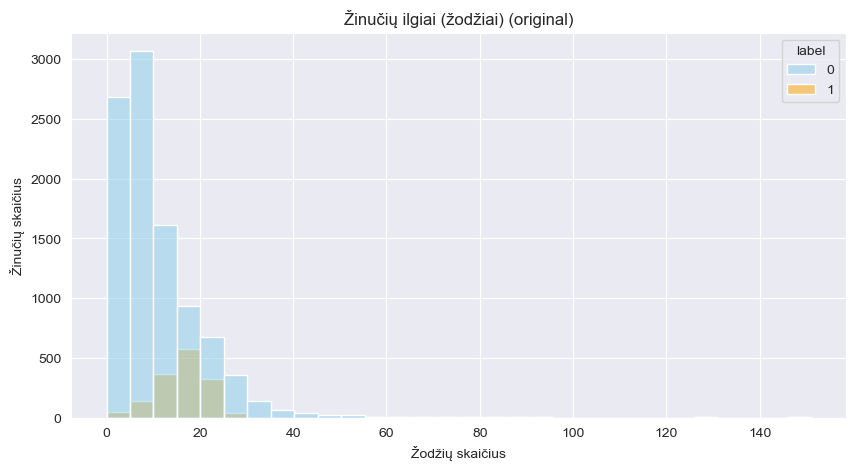

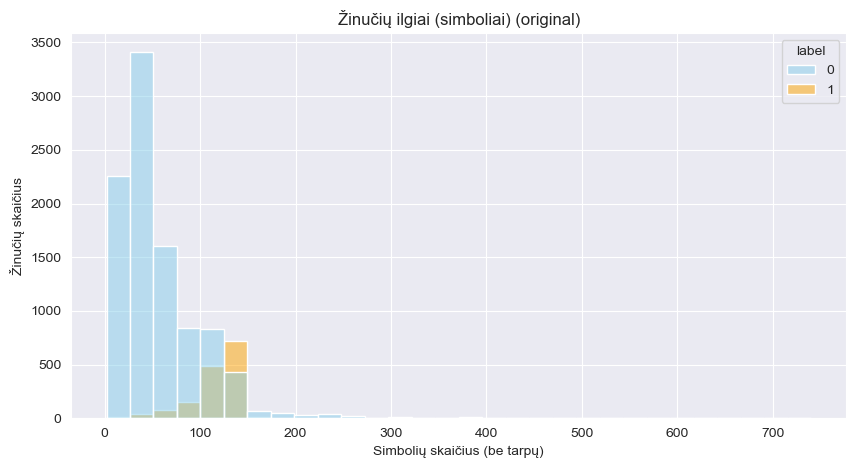

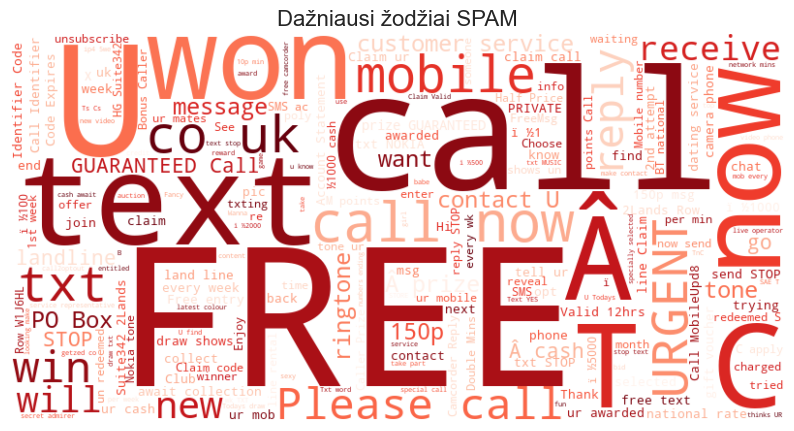

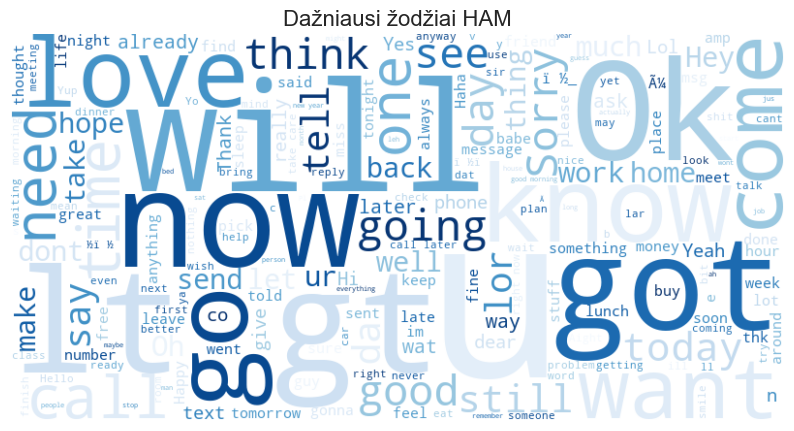

Top SPAM: [('to', 1208), ('a', 718), ('your', 374), ('or', 370), ('call', 368), ('the', 353), ('2', 338), ('for', 338), ('you', 328), ('is', 285), ('Call', 272), ('on', 271), ('have', 253), ('and', 238), ('from', 232), ('ur', 214), ('with', 202), ('&', 196), ('4', 186), ('of', 186)]
Top HAM: [('to', 3068), ('you', 2920), ('I', 2875), ('the', 2048), ('a', 1946), ('i', 1478), ('and', 1477), ('in', 1470), ('u', 1296), ('is', 1283), ('my', 1240), ('me', 1078), ('of', 997), ('for', 956), ('that', 797), ('it', 751), ('your', 747), ('on', 704), ('have', 695), ('at', 667)]


In [37]:
df['word_count'] = df['text'].apply(lambda x: len([w for w in str(x).split() if w.isalpha()]))


df['char_count'] = df['text'].apply(lambda x: len(str(x).replace(" ", "")))

def plot_histograms(df, suffix=""):
    plt.figure(figsize=(10,5))
    sns.histplot(df, x='word_count', hue='label', bins=30, kde=False, palette={0:'skyblue',1:'orange'})
    plt.xlabel("Žodžių skaičius")
    plt.ylabel("Žinučių skaičius")
    plt.title(f"Žinučių ilgiai (žodžiai) {suffix}")
    plt.show()

    plt.figure(figsize=(10,5))
    sns.histplot(df, x='char_count', hue='label', bins=30, kde=False, palette={0:'skyblue',1:'orange'})
    plt.xlabel("Simbolių skaičius (be tarpų)")
    plt.ylabel("Žinučių skaičius")
    plt.title(f"Žinučių ilgiai (simboliai) {suffix}")
    plt.show()

plot_histograms(df, "(original)")

def plot_wordcloud(df, label, title):
    text = " ".join(df[df['label']==label]['text'])
    plt.figure(figsize=(10,6))
    wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds' if label==1 else 'Blues').generate(text)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

plot_wordcloud(df, 1, "Dažniausi žodžiai SPAM")
plot_wordcloud(df, 0, "Dažniausi žodžiai HAM")

def get_top_words(df, label, n=20):
    words = " ".join(df[df['label']==label]['text']).split()
    counter = Counter(words)
    return counter.most_common(n)

top_spam = get_top_words(df, 1)
top_ham = get_top_words(df, 0)
print("Top SPAM:", top_spam)
print("Top HAM:", top_ham)

In [38]:
# Sukuriame savo stop_words sąrašą
my_stop_words = {
    'the', 'a', 'an', 'and', 'or', 'in', 'on', 'of', 'to', 'for', 'is', 'are',
    'was', 'were', 'be', 'been', 'it', 'this', 'that', 'with', 'as', 'by', 'at',
    'from', 'about', 'into', 'up', 'out', 'so', 'if', 'then', 'but'
}

def remove_stopwords(text):
    words = str(text).lower().split()
    filtered = [w for w in words if w.isalpha() and w not in my_stop_words]
    return " ".join(filtered)

# Sukuriame kopiją ir pritaikome funkciją
df_sw = df.copy()
df_sw['text'] = df_sw['text'].apply(remove_stopwords)


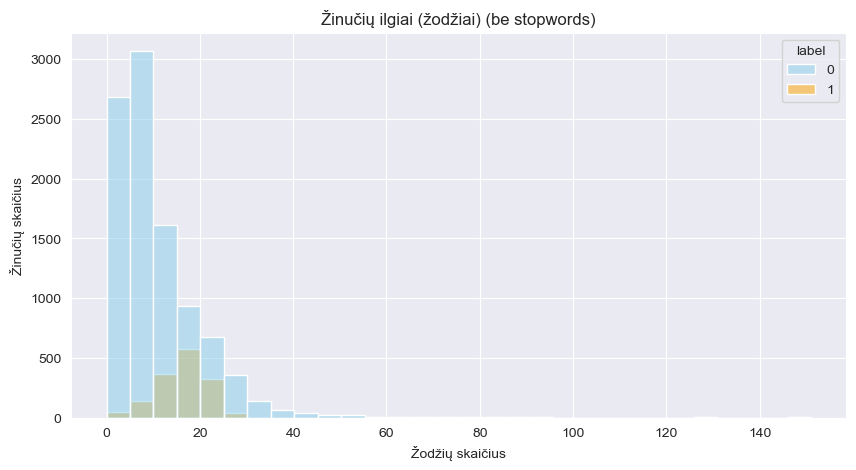

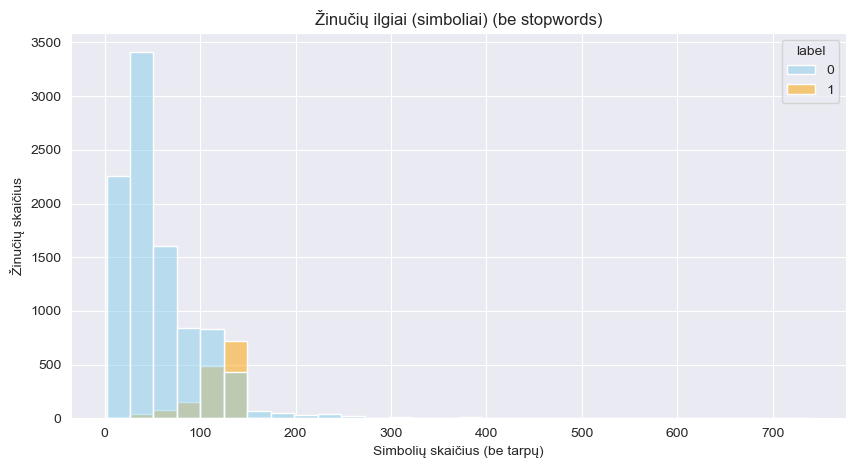

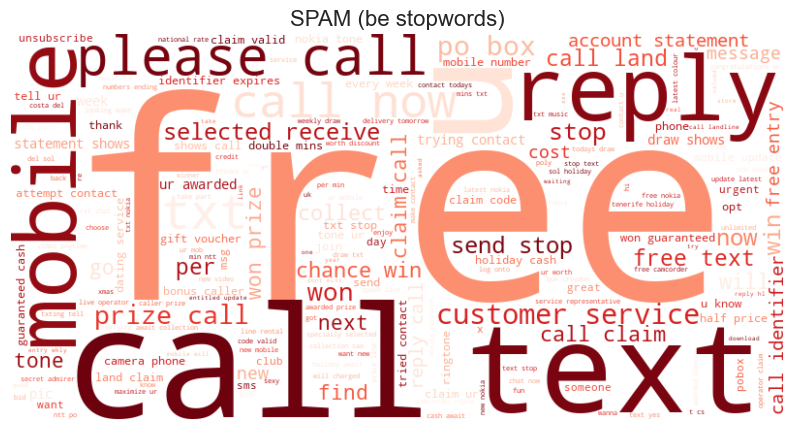

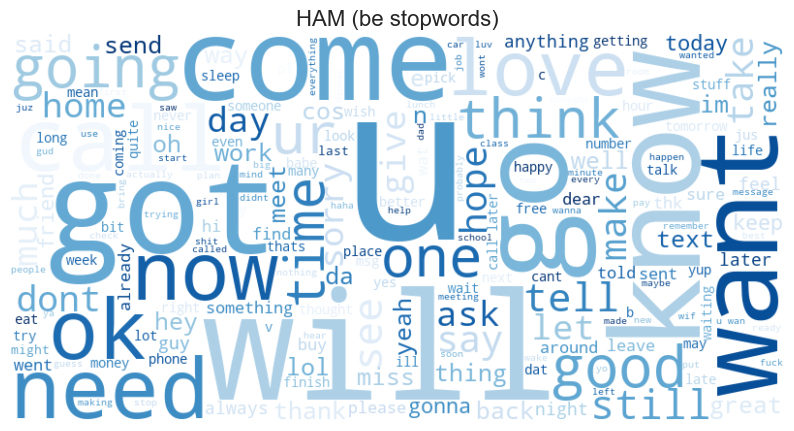

Top SPAM (be stopwords): [('call', 681), ('your', 526), ('you', 504), ('free', 360), ('ur', 288), ('txt', 272), ('have', 267), ('u', 232), ('text', 224), ('mobile', 218), ('claim', 210), ('reply', 202), ('now', 186), ('stop', 179), ('our', 170), ('get', 164), ('just', 153), ('new', 138), ('send', 131), ('only', 130)]
Top HAM (be stopwords): [('i', 4353), ('you', 3334), ('u', 1755), ('my', 1486), ('me', 1174), ('have', 869), ('your', 827), ('not', 769), ('can', 713), ('do', 683), ('will', 667), ('we', 595), ('get', 586), ('just', 573), ('when', 541), ('how', 491), ('ur', 476), ('go', 473), ('what', 471), ('all', 464)]


In [39]:
plot_histograms(df_sw, "(be stopwords)")
plot_wordcloud(df_sw, 1, "SPAM (be stopwords)")
plot_wordcloud(df_sw, 0, "HAM (be stopwords)")

top_spam_sw = get_top_words(df_sw, 1)
top_ham_sw = get_top_words(df_sw, 0)
print("Top SPAM (be stopwords):", top_spam_sw)
print("Top HAM (be stopwords):", top_ham_sw)


# Vektorizavimas/mokymas


In [40]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=5),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}
nlp = spacy.load("en_core_web_md")

def vectorize_text(df, method="bow", vectorizer=None):
    texts = df['text'].astype(str).tolist()

    if method == "bow":
        if vectorizer is None:
            vectorizer = CountVectorizer()
            X = vectorizer.fit_transform(texts)   # treniruojam + kuriam zodyna
        else:
            X = vectorizer.transform(texts)       # naudojam esama zodyna

    elif method == "tfidf":
        if vectorizer is None:
            vectorizer = TfidfVectorizer()
            X = vectorizer.fit_transform(texts)
        else:
            X = vectorizer.transform(texts)

    elif method == "spacy_w2v":
        # spacy nereikia vectorizer
        X = np.array([nlp(t).vector for t in texts])
        vectorizer = None
    else:
        raise ValueError("Nežinomas metodas")

    return X, vectorizer

def train_and_evaluate(models, X_train, X_test, y_train, y_test, title=""):
    results = []
    print(f"\n=== {title} ===")
    for name, model in models.items():
        print(f"🔹 Treniruojamas: {name}")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results.append((name, acc))
        print(f"✅ Tikslumas: {acc:.4f}")
        print(classification_report(y_test, y_pred, digits=3))
        print("-"*50)
    return pd.DataFrame(results, columns=["Model", "Accuracy"]).sort_values(by="Accuracy", ascending=False)

def plot_results(df, title=""):
    df = df.sort_values(by="Accuracy", ascending=True)
    plt.figure(figsize=(10,6))
    plt.barh(df["Model"], df["Accuracy"], color='skyblue')
    for i, v in enumerate(df["Accuracy"]):
        plt.text(v + 0.002, i, f"{v:.3f}", va='center')
    plt.xlabel("Tikslumas")
    plt.title(title)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

# Train/Test padalinimas bei mokymas



### Vektorizacija: BOW ###

=== BOW - original ===
🔹 Treniruojamas: Logistic Regression
✅ Tikslumas: 0.9933
              precision    recall  f1-score   support

           0      0.992     1.000     0.996      1910
           1      1.000     0.953     0.976       319

    accuracy                          0.993      2229
   macro avg      0.996     0.976     0.986      2229
weighted avg      0.993     0.993     0.993      2229

--------------------------------------------------
🔹 Treniruojamas: Linear SVM
✅ Tikslumas: 0.9964
              precision    recall  f1-score   support

           0      0.997     0.999     0.998      1910
           1      0.994     0.981     0.987       319

    accuracy                          0.996      2229
   macro avg      0.995     0.990     0.993      2229
weighted avg      0.996     0.996     0.996      2229

--------------------------------------------------
🔹 Treniruojamas: Random Forest
✅ Tikslumas: 0.9960
              precision    recall  

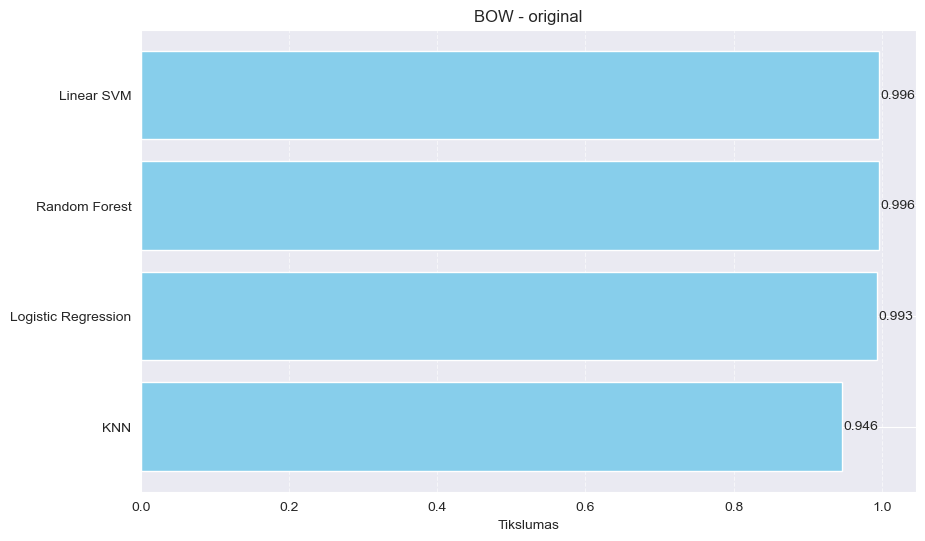


=== BOW - no_stopwords ===
🔹 Treniruojamas: Logistic Regression
✅ Tikslumas: 0.9901
              precision    recall  f1-score   support

           0      0.989     1.000     0.994      1910
           1      1.000     0.931     0.964       319

    accuracy                          0.990      2229
   macro avg      0.994     0.966     0.979      2229
weighted avg      0.990     0.990     0.990      2229

--------------------------------------------------
🔹 Treniruojamas: Linear SVM
✅ Tikslumas: 0.9964
              precision    recall  f1-score   support

           0      0.996     1.000     0.998      1910
           1      1.000     0.975     0.987       319

    accuracy                          0.996      2229
   macro avg      0.998     0.987     0.993      2229
weighted avg      0.996     0.996     0.996      2229

--------------------------------------------------
🔹 Treniruojamas: Random Forest
✅ Tikslumas: 0.9933
              precision    recall  f1-score   support

     

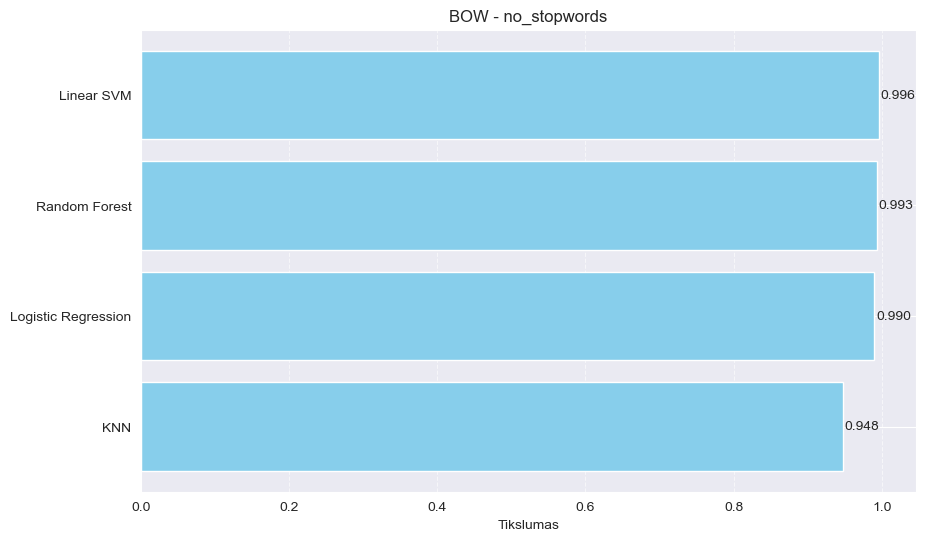



### Vektorizacija: TFIDF ###

=== TFIDF - original ===
🔹 Treniruojamas: Logistic Regression
✅ Tikslumas: 0.9753
              precision    recall  f1-score   support

           0      0.972     1.000     0.986      1910
           1      1.000     0.828     0.906       319

    accuracy                          0.975      2229
   macro avg      0.986     0.914     0.946      2229
weighted avg      0.976     0.975     0.974      2229

--------------------------------------------------
🔹 Treniruojamas: Linear SVM
✅ Tikslumas: 0.9969
              precision    recall  f1-score   support

           0      0.996     1.000     0.998      1910
           1      1.000     0.978     0.989       319

    accuracy                          0.997      2229
   macro avg      0.998     0.989     0.994      2229
weighted avg      0.997     0.997     0.997      2229

--------------------------------------------------
🔹 Treniruojamas: Random Forest
✅ Tikslumas: 0.9955
              precision    reca

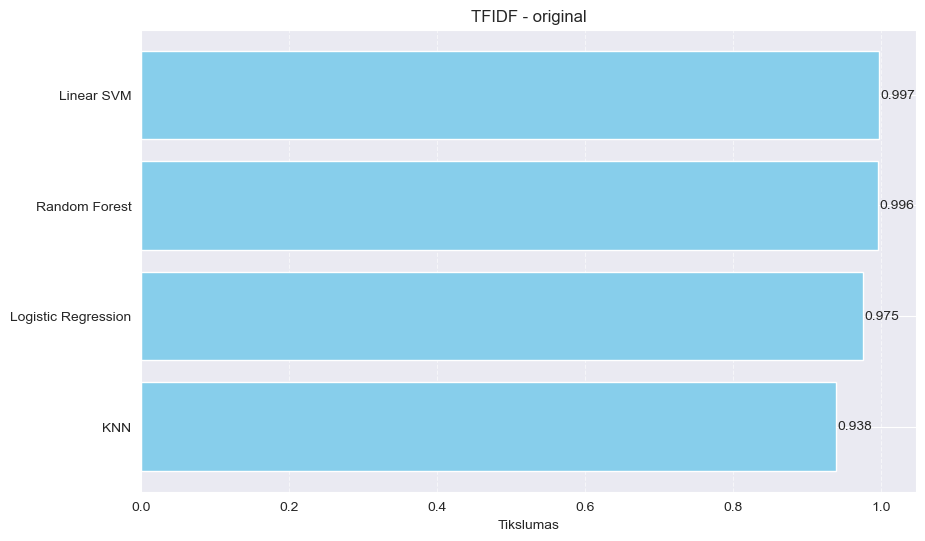


=== TFIDF - no_stopwords ===
🔹 Treniruojamas: Logistic Regression
✅ Tikslumas: 0.9690
              precision    recall  f1-score   support

           0      0.966     0.999     0.982      1910
           1      0.992     0.790     0.880       319

    accuracy                          0.969      2229
   macro avg      0.979     0.894     0.931      2229
weighted avg      0.970     0.969     0.968      2229

--------------------------------------------------
🔹 Treniruojamas: Linear SVM
✅ Tikslumas: 0.9942
              precision    recall  f1-score   support

           0      0.993     1.000     0.997      1910
           1      1.000     0.959     0.979       319

    accuracy                          0.994      2229
   macro avg      0.997     0.980     0.988      2229
weighted avg      0.994     0.994     0.994      2229

--------------------------------------------------
🔹 Treniruojamas: Random Forest
✅ Tikslumas: 0.9942
              precision    recall  f1-score   support

   

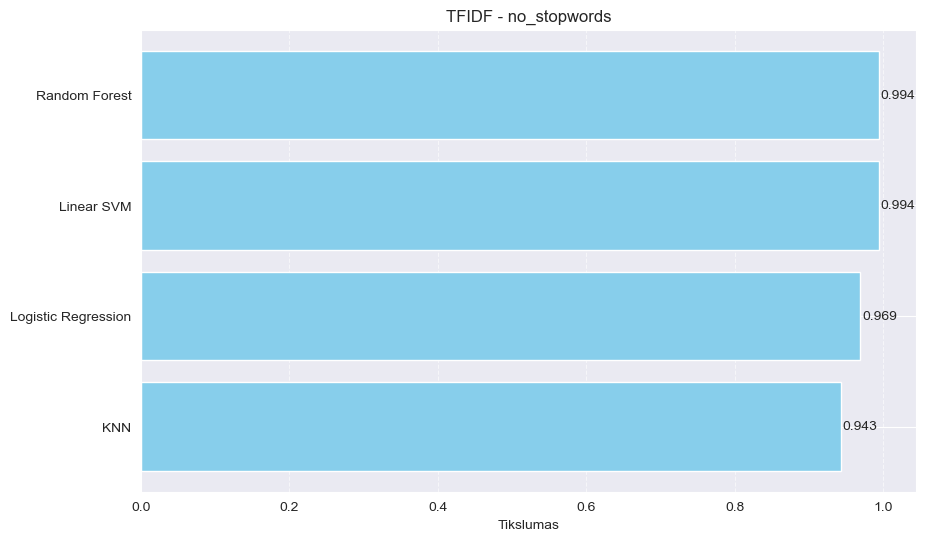



### Vektorizacija: SPACY_W2V ###

=== SPACY_W2V - original ===
🔹 Treniruojamas: Logistic Regression
✅ Tikslumas: 0.9538
              precision    recall  f1-score   support

           0      0.962     0.985     0.973      1910
           1      0.894     0.768     0.826       319

    accuracy                          0.954      2229
   macro avg      0.928     0.876     0.900      2229
weighted avg      0.952     0.954     0.952      2229

--------------------------------------------------
🔹 Treniruojamas: Linear SVM
✅ Tikslumas: 0.9646
              precision    recall  f1-score   support

           0      0.973     0.986     0.979      1910
           1      0.911     0.834     0.871       319

    accuracy                          0.965      2229
   macro avg      0.942     0.910     0.925      2229
weighted avg      0.964     0.965     0.964      2229

--------------------------------------------------
🔹 Treniruojamas: Random Forest
✅ Tikslumas: 0.9933
              precision

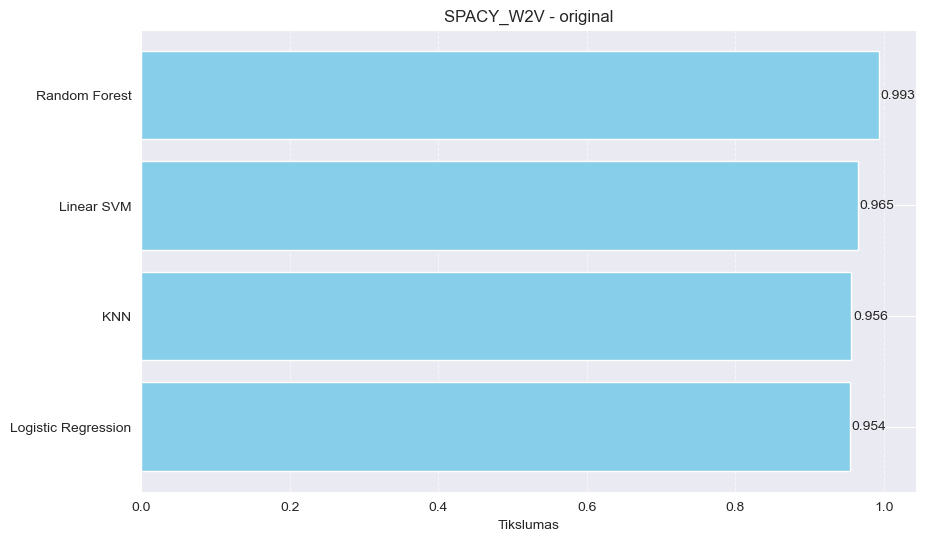


=== SPACY_W2V - no_stopwords ===
🔹 Treniruojamas: Logistic Regression
✅ Tikslumas: 0.9363
              precision    recall  f1-score   support

           0      0.952     0.975     0.963      1910
           1      0.824     0.705     0.760       319

    accuracy                          0.936      2229
   macro avg      0.888     0.840     0.862      2229
weighted avg      0.934     0.936     0.934      2229

--------------------------------------------------
🔹 Treniruojamas: Linear SVM
✅ Tikslumas: 0.9462
              precision    recall  f1-score   support

           0      0.963     0.975     0.969      1910
           1      0.837     0.774     0.805       319

    accuracy                          0.946      2229
   macro avg      0.900     0.875     0.887      2229
weighted avg      0.945     0.946     0.945      2229

--------------------------------------------------
🔹 Treniruojamas: Random Forest
✅ Tikslumas: 0.9883
              precision    recall  f1-score   support


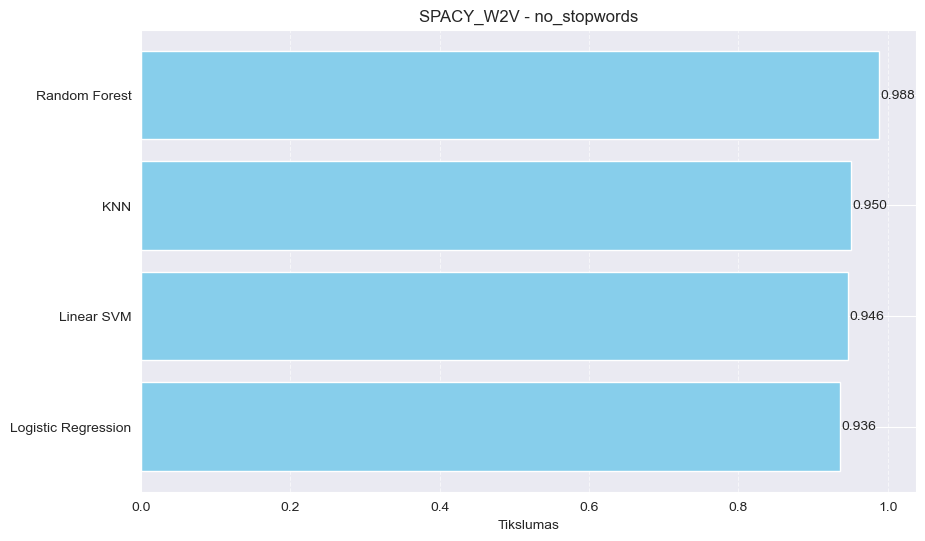

In [41]:
y = df['label'].values
results_all = {}
for method in ["bow", "tfidf", "spacy_w2v"]:
    print(f"\n\n### Vektorizacija: {method.upper()} ###")
    for data, label in [(df, "original"), (df_sw, "no_stopwords")]:
        X, vectorizer = vectorize_text(data, method)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
        results = train_and_evaluate(models, X_train, X_test, y_train, y_test, title=f"{method.upper()} - {label}")
        results_all[f"{method}_{label}"] = results
        plot_results(results, title=f"{method.upper()} - {label}")

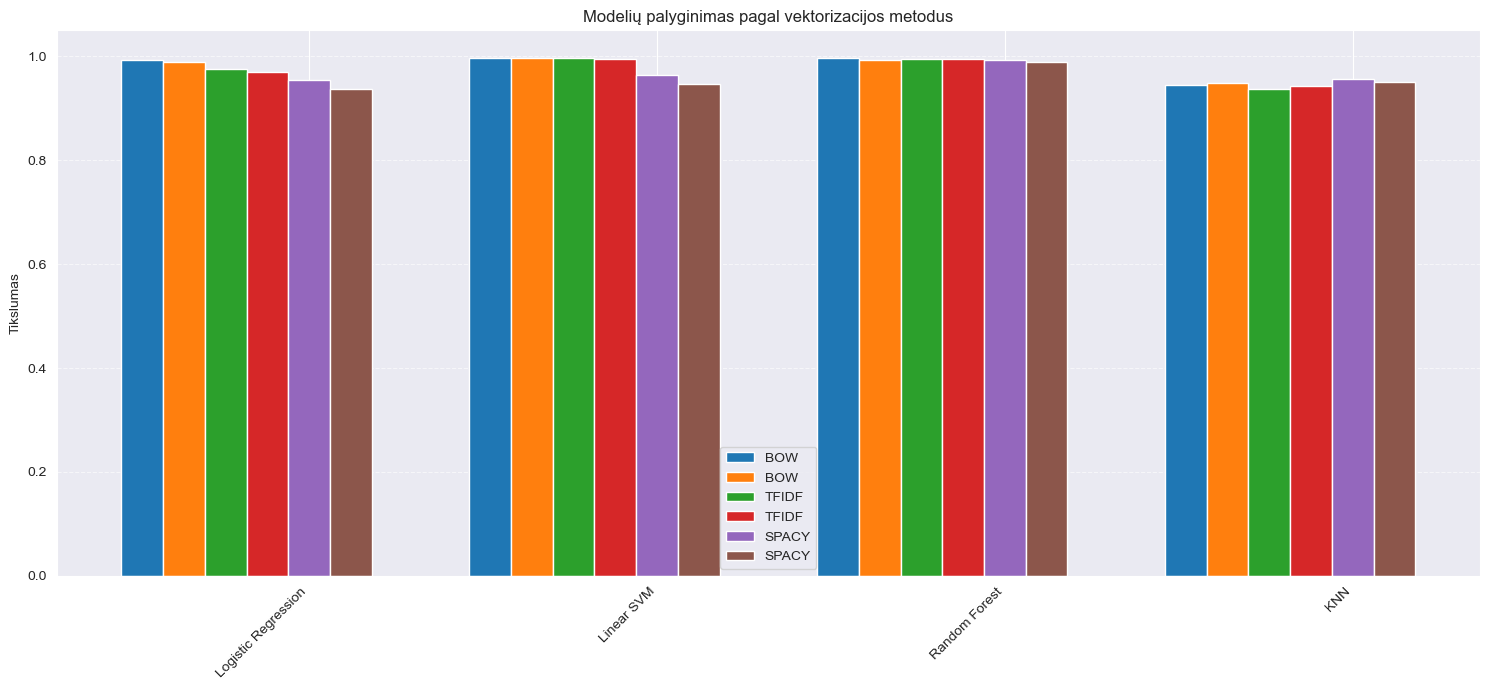

In [42]:
comparison_df = pd.DataFrame({"Model": list(models.keys())})
for key, df_res in results_all.items():
    comparison_df = comparison_df.merge(df_res, on="Model", how="left", suffixes=("", f"_{key}"))

comparison_df.columns = ["Model"] + [f"Accuracy_{k}" for k in results_all.keys()]

x = np.arange(len(comparison_df))
width = 0.12
plt.figure(figsize=(15,7))
for i, col in enumerate(comparison_df.columns[1:]):
    plt.bar(x + i*width - width*4, comparison_df[col], width, label=col.split("_")[1].upper())

plt.xticks(x, comparison_df["Model"], rotation=45, ha='right')
plt.ylabel("Tikslumas")
plt.title("Modelių palyginimas pagal vektorizacijos metodus")
plt.ylim(0,1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Ensemble

In [43]:
base_models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=5)),
    ('Linear SVM', LinearSVC(random_state=5)),
    ('Random Forest', RandomForestClassifier(n_estimators=200, random_state=5))
]

In [44]:
X, vectorizer = vectorize_text(df, 'tfidf')
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [45]:
meta_model_svc = LinearSVC(random_state=5)

stack_svc = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model_svc,
    passthrough=False,
    cv=5
)

stack_svc.fit(X_train, y_train)
y_pred = stack_svc.predict(X_test)

print("✅ Stacking tikslumas:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))


✅ Stacking tikslumas: 0.9991027366532077
              precision    recall  f1-score   support

           0      1.000     0.999     0.999      1910
           1      0.994     1.000     0.997       319

    accuracy                          0.999      2229
   macro avg      0.997     0.999     0.998      2229
weighted avg      0.999     0.999     0.999      2229



# Testavimas su https://archive.ics.uci.edu/dataset/228/sms+spam+collection

In [63]:
data = pd.read_csv('SMSSpamCollection',delimiter="\t",header=None)
data.columns = ["label","text"]

data['label'] = data['label'].map({'spam': 1, 'ham': 0})

In [64]:
X_df, vectorizer = vectorize_text(df, 'tfidf', vectorizer = vectorizer)

X_data, vectorizer = vectorize_text(data, 'tfidf', vectorizer = vectorizer)

In [65]:
stack_svc.fit(X_df, df['label'])

y_pred_data = stack_svc.predict(X_data)

print(accuracy_score(data['label'], y_pred_data))

1.0
